In [20]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
import pickle
import nltk
from nltk.corpus import wordnet as wn

In [21]:
# Read data
df = pd.read_csv("../Resources/winemag-data-190314.csv")

In [22]:
#Create groups for points
conditions = [
    (df.points>=95),
    (df.points>=90),
    (df.points>=85),
    (df.points>=80)
    ]

# create a list of the values we want to assign for each condition
values = ['95-100','90-95', '85-90', '80-85']

# create a new column and use np.select to assign values to it using our lists as arguments
df['points_group']=np.select(conditions, values)
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,points_group
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0,85-90
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0,85-90
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0,85-90
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0,85-90
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0,85-90


In [23]:
df.variety.nunique()

758

In [24]:
df.groupby('points_group').count()
# df.groupby('points_group').nunique()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
points_group,,,,,,,,,,,,,,,
80-85,12985,12981,12985,7948,12985,12383,12981,10704,4980,8933,8583,12985,12985,12985,12265
85-90,73091,73054,73091,49506,73091,68179,73054,60946,26067,60060,56713,73091,73090,73091,70026
90-95,52330,52310,52330,41393,52330,48493,52310,44324,22512,45018,43075,52330,52330,52330,50983
95-100,3211,3211,3211,2588,3211,2904,3211,2757,1226,2689,2597,3211,3211,3211,3109


In [6]:
plt.scatter(x=df.points,y=df.price, marker="o", facecolors="red", edgecolors="black")

SyntaxError: invalid character in identifier (<ipython-input-6-0ecb51f66033>, line 1)

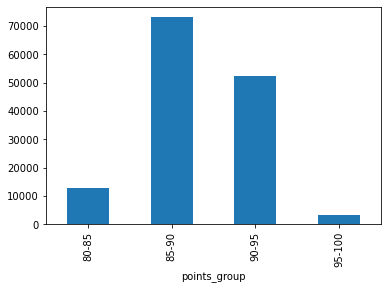

In [7]:
df.groupby('points_group')['points'].count().plot(kind='bar')

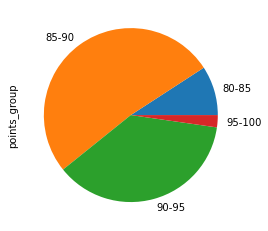

In [8]:
df.groupby('points_group')['points_group'].count().plot(kind='pie')

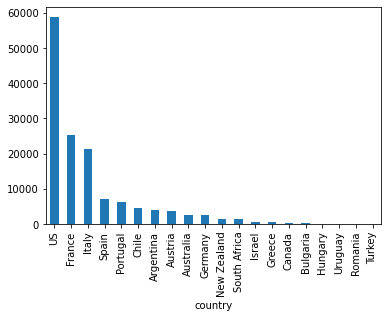

In [9]:
df.groupby('country')['country'].count().sort_values(ascending=False).head(20).plot(kind='bar')

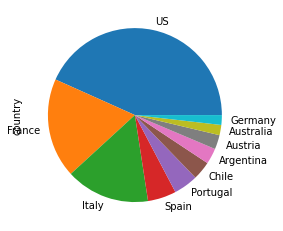

In [10]:
df.groupby('country')['country'].count().sort_values(ascending=False).head(10).plot(kind='pie')

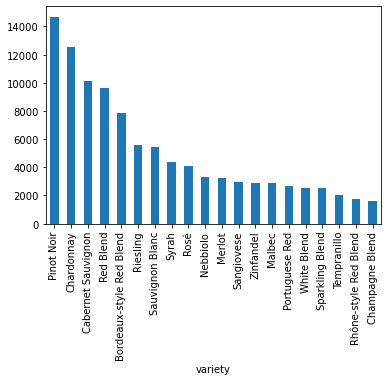

In [11]:
df.groupby('variety')['variety'].count().sort_values(ascending=False).head(20).plot(kind='bar')

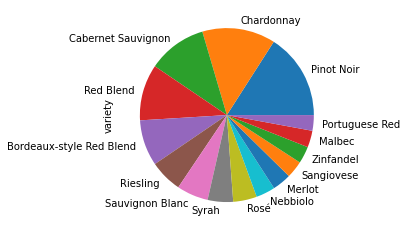

In [12]:
df.groupby('variety')['variety'].count().sort_values(ascending=False).head(15).plot(kind='pie')

In [25]:
# Filter needed columns
# df_filtered = df.loc[df.points_group=='90-95']
df_filtered = df[['description', 'variety','country','winery']]
df_filtered.head()

,description,variety,country,winery
0,"Aromas include tropical fruit, broom, brimston...",White Blend,Italy,Nicosia
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red,Portugal,Quinta dos Avidagos
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,US,Rainstorm
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling,US,St. Julian
4,"Much like the regular bottling from 2012, this...",Pinot Noir,US,Sweet Cheeks


In [26]:
# Drop NAs and duplicates
df_filtered = df_filtered.dropna(how='any')
df_filtered=df_filtered.drop_duplicates()
df_filtered.head()

,description,variety,country,winery
0,"Aromas include tropical fruit, broom, brimston...",White Blend,Italy,Nicosia
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red,Portugal,Quinta dos Avidagos
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,US,Rainstorm
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling,US,St. Julian
4,"Much like the regular bottling from 2012, this...",Pinot Noir,US,Sweet Cheeks


In [27]:
# Split the data into train and test
X = df_filtered['description']
y = df_filtered['variety']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# train_data = df_filtered.loc[df_filtered['description'].isin(X_train)]
# test_data = df_filtered.loc[df_filtered['description'].isin(X_test)]
# train_data = train_data.drop_duplicates()
# test_data = test_data.drop_duplicates()

In [28]:
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
# X_train=[' '.join([stemmer.stem(word) for word in text.split(' ')])
#           for text in X_train]

from nltk.stem import WordNetLemmatizer
lemmer=WordNetLemmatizer()
X_train=[' '.join([lemmer.lemmatize(word) for word in text.split(' ')])
          for text in X_train]

In [29]:
# Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, 
# which builds a dictionary of features and transforms documents to feature vectors:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

# # Train data:
# description_train_counts = count_vect.fit_transform(train_data.description)
# winery_train_counts = count_vect.fit_transform(train_data.winery)
# country_train_counts = count_vect.fit_transform(train_data.country)

# # Test data:
# description_test_counts = count_vect.fit_transform(test_data.description)
# winery_test_counts = count_vect.fit_transform(test_data.winery)
# country_test_counts = count_vect.fit_transform(test_data.country)

X_train_counts.shape

(106158, 28635)

In [30]:
# A dictionary of feature indices
count_vect.vocabulary_.get(u'algorithm')
dict = count_vect.vocabulary_

In [67]:
vocabs = pd.DataFrame(dict,index=['Frequency']).T.reset_index()
vocabs = vocabs.rename(columns = {'index': 'Word'})
# .sort_values(by='Frequency', ascending=False)
vocabs.head()

,Word,Frequency
0,crisp,6747
1,and,1439
2,clean,5487
3,this,25603
4,is,13286


In [68]:
tags=nltk.pos_tag(vocabs.Word)

In [69]:
adj_adv = [word for (word, tag) in tags if (tag=='JJ') or (tag=='RB')]
adj_adv

['ripe',
 'honeyed',
 'attractive',
 'packed',
 'ready',
 'rich',
 'well',
 'concentrated',
 'great',
 'otherwise',
 'apricot',
 'golden',
 'delicious',
 'here',
 'rustic',
 'right',
 'fine',
 'awkward',
 'cherry',
 'berry',
 'cool',
 'herbal',
 'palate',
 'full',
 'still',
 'fresh',
 'several',
 'baked',
 'finish',
 'friendly',
 'brambly',
 'black',
 'immediately',
 'unfold',
 'accessible',
 'satin',
 'medium',
 'long',
 'understated',
 'rather',
 'light',
 'red',
 'subtle',
 'earthy',
 'aromas',
 'appropriately',
 'tannic',
 'richly',
 'approachable',
 'nonetheless',
 'toasted',
 'fortuitous',
 'lemon',
 'fragrant',
 'whistle',
 'real',
 'revive',
 'floral',
 'sweet',
 'caramel',
 'too',
 'fat',
 'slightly',
 'such',
 'glazed',
 'tiny',
 'sixth',
 'syrah',
 'sangiovese',
 'truly',
 'call',
 'menthol',
 'earth',
 'lead',
 'rosso',
 'dimensional',
 'forward',
 'close',
 'so',
 'enjoy',
 'now',
 'pipe',
 'wild',
 'balsamic',
 'together',
 'tight',
 'solid',
 'alongside',
 'taut',
 'gree

In [31]:
filtered_vocabs=vocabs.loc[vocabs.Word.isin(adj_adv)].sort_values(by='Frequency',ascending=False)
filtered_vocabs.head()

NameError: name 'vocabs' is not defined

In [32]:
# Use the 'fit' to fit our estimator to the data and 
# secondly the 'transform' to transform our count-matrix to a tf-idf representation

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

# # Train data
# tf_transformer_description = TfidfTransformer(use_idf=False).fit(description_train_counts)
# description_train_tf = tf_transformer_description.transform(description_train_counts)

# tf_transformer_winery = TfidfTransformer(use_idf=False).fit(winery_train_counts)
# winery_train_tf = tf_transformer_winery.transform(winery_train_counts)

# tf_transformer_country = TfidfTransformer(use_idf=False).fit(country_train_counts)
# country_train_tf = tf_transformer_country.transform(country_train_counts)

# # Test data:
# tf_transformer_description_test = TfidfTransformer(use_idf=False).fit(description_test_counts)
# description_test_tf = tf_transformer_description_test.transform(description_test_counts)

# tf_transformer_winery_test = TfidfTransformer(use_idf=False).fit(winery_test_counts)
# winery_test_tf = tf_transformer_winery_test.transform(winery_train_counts)

# tf_transformer_country_test = TfidfTransformer(use_idf=False).fit(country_test_counts)
# country_test_tf = tf_transformer_country_test.transform(country_test_counts)

X_train_tf.shape

(106158, 28635)

In [33]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# # Train data:
# description_train_tfidf = tfidf_transformer.fit_transform(description_train_counts)
# winery_train_tfidf = tfidf_transformer.fit_transform(winery_train_counts)
# country_train_tfidf = tfidf_transformer.fit_transform(country_train_counts)

# # Test data:
# description_test_tfidf = tfidf_transformer.fit_transform(description_test_counts)
# winery_test_tfidf = tfidf_transformer.fit_transform(winery_test_counts)
# country_test_tfidf = tfidf_transformer.fit_transform(country_test_counts)

X_train_tfidf.shape

(106158, 28635)

In [34]:
# from scipy.sparse import hstack

# # Train data:
# X_train_dtm = hstack((description_train_tfidf,winery_train_tfidf))
# X_train_dtm = hstack((X_train_dtm,country_train_tfidf))

# # Test data:
# X_test_dtm = hstack((description_test_tfidf,winery_test_tfidf))
# X_test_dtm = hstack((X_test_dtm,country_test_tfidf))

# X_train_dtm

In [73]:
# Train the Multinomial NB model
clf = MultinomialNB().fit(X_train_tfidf,y_train)

In [35]:
# ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial 
# naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics 
# from the complement of each class to compute the model’s weights. The inventors of CNB show empirically that the 
# parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB 
# on text classification tasks.

# Train the Complement NB model
clf2 = ComplementNB().fit(X_train_tfidf,y_train)

In [41]:
# Test the model with an input
data = ['Fruity Chocolate']
X_new_counts = count_vect.transform(data)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf2.predict(X_new_tfidf)
predicted

array(['Cabernet Sauvignon'], dtype='<U35')

In [76]:
for doc, category in zip(data, predicted):
    print('%r => %s' % (doc, category))

'Fruity' => Chardonnay
'Dry' => Pinot Noir


In [77]:
# Accuracy of the Multinomial NB model
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
predicted_test = clf.predict(X_test_tfidf)
np.mean(predicted_test == y_test)

0.34965805685864465

In [78]:
# Accuracy of the Complement NB model
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
predicted_test = clf2.predict(X_test_tfidf)
np.mean(predicted_test == y_test)

0.4874244051319731

In [ ]:
# Save model

vectorizer_file = "tokenizer.sklearn"
pickle.dump(count_vect, open(vectorizer_file,'wb'))

tokenizer_file = "vectorizer.sklearn"
pickle.dump(tfidf_transformer, open(tokenizer_file,'wb'))

NBModel = 'sentiment_scoring.sklearn'
pickle.dump(clf2, open(NBModel, 'wb'))

In [ ]:
# Reusing model
vectorizer = pickle.load(open(vectorizer_file, 'rb'))
tokenizer = pickle.load(open(tokenizer_file, 'rb'))
nbModel = pickle.load(open(NBModel, 'rb'))

user_input=['fruity','apple','dry','chocolate','red','italy']
X_new = vectorizer.transform(user_input)
X_new = tokenizer.transform(X_new)
result = nbModel.predict(X_new)
print(result)

In [53]:
# deep learning

In [94]:
from sklearn.preprocessing import MaxAbsScaler,LabelEncoder
X_scaler = MaxAbsScaler().fit(X_train_tfidf)
X_train_scaled = X_scaler.transform(X_train_tfidf)
# X_test_scaled = X_scaler.transform(X_test_tfidf)

In [110]:
from tensorflow.keras.utils import to_categorical
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(X_train,y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_x_train = label_encoder.transform(X_train)
# encoded_y_test = label_encoder.transform(y_test)

# # Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
x_train_categorical = to_categorical(encoded_x_train)
# y_test_categorical = to_categorical(encoded_y_test)

TypeError: fit() takes 2 positional arguments but 3 were given

In [100]:
X_train_scaled.shape

(106158, 28635)

In [99]:
y_train_categorical.shape

(106158, 704)

In [87]:
X_train_tfidf.shape

(106158, 28635)

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Create model and add layers
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=1))
# model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=704, activation='softmax'))

In [116]:
base_model = Sequential()
base_model.add(Dense(64, activation='relu', input_shape=(28635,)))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(704, activation='softmax'))
base_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                1832704   
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 704)               45760     
Total params: 1,882,624
Trainable params: 1,882,624
Non-trainable params: 0
_________________________________________________________________


In [117]:
# Compile and fit the model
base_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [118]:
base_model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=2
)

MemoryError: Unable to allocate 22.6 GiB for an array with shape (106158, 28635) and data type float64